In [3]:
# Imports
import torch
from torch.distributions import Normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

In [4]:
images, ground_truth = torch.load('MNIST/processed/training.pt')

In [5]:
print(images.shape)
print(ground_truth.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [6]:
print(torch.min(images[0]))
print(torch.max(images[0]))

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)


In [7]:
images[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

tensor(3)


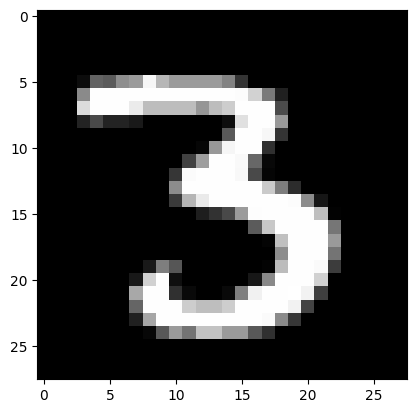

In [8]:
image_index = 12
print(ground_truth[image_index])
plt.imshow(images[image_index], cmap='gray')

In [9]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, path):
        self.images, self.ground_truth = torch.load(path)
        
    def __getitem__(self, idx):
        """
        Returns image with index idx
        """
        x = self.images[idx].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) 
        return x
    
    def __len__(self):
        return len(self.ground_truth)

In [10]:
# make datasets
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [11]:
train_dataset[15].shape
# train_dataset[15]

torch.Size([784])

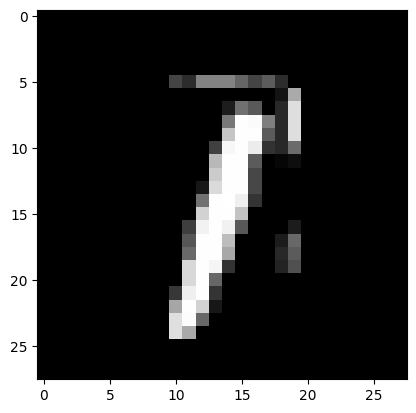

In [12]:
plt.imshow(train_dataset[67].numpy().reshape((28,28)), cmap='gray')


### AutoEncoder
$MSE =  \frac{1}{N} \sum_{i=1}^{n}(X_i - \hat{X}_i)^2$

Architecture:

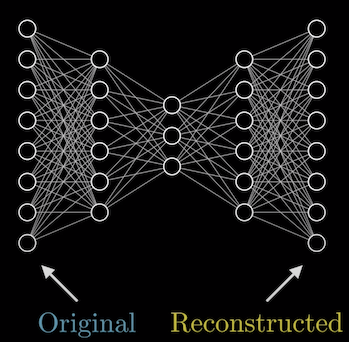

In [13]:
import torch.nn as nn 

class AutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim=128):
        super().__init__()
    
        # two fully connected layers for encoder (input_shape -> latent_dim)
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        
        # two fully connected layers for decoder (128 -> input_shape)
        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
        
    def forward(self, x):
        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        return x_hat
        
    def run_encoder(self,x):
        output = F.relu(self.encoder_l1(x))
        latent = F.relu(self.encoder_l2(output)) 
        return latent # latent representation
    
    def run_decoder(self,latent):
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output))
        return x_hat # reconstructed images
    


### Model Training

In [14]:
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

# get shape of input data
image_shape = train_dataset[0].shape[0]
print(image_shape)

# Initialize AutoEncoder
model = AutoEncoder(input_shape=image_shape)
model.cuda()
model.train()

784


AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

In [15]:
batch_test = torch.randn(128,784).cuda() # batch_size = 128
output = model(batch_test)

print(output)
print(output.shape)


tensor([[0.0672, 0.1420, 0.0909,  ..., 0.0000, 0.0000, 0.0265],
        [0.0350, 0.1140, 0.1241,  ..., 0.0000, 0.0000, 0.0000],
        [0.1086, 0.1698, 0.0482,  ..., 0.0000, 0.0000, 0.0253],
        ...,
        [0.0714, 0.2162, 0.0690,  ..., 0.0000, 0.0000, 0.0222],
        [0.0914, 0.1432, 0.0615,  ..., 0.0000, 0.0000, 0.0648],
        [0.0650, 0.2354, 0.0726,  ..., 0.0000, 0.0000, 0.0254]],
       device='cuda:0', grad_fn=<ReluBackward0>)
torch.Size([128, 784])


In [16]:
import torch.optim as optim
# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)

# Loss
mse = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    
    for batch_features in train_loader:
        batch_features = batch_features.cuda()
        
        optimizer.zero_grad()
        
        # compute reconstruction
        outputs = model(batch_features)
        
        # Debugging print statements
        # if outputs is None:
        #     print("model output is None")
        #     continue
        
        # compute training reconstruction loss
        train_loss = mse(outputs, batch_features)
    
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add mini-batch training loss to epoch loss
        loss += train_loss.item()
        
    # compute epoch training loss
    loss = loss / len(train_loader)
    
    if epoch %5 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))
    
    
print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))


epoch : 1/100, loss = 1994.447852
epoch : 6/100, loss = 864.352264
epoch : 11/100, loss = 792.841098
epoch : 16/100, loss = 760.831165
epoch : 21/100, loss = 741.818446
epoch : 26/100, loss = 728.488605
epoch : 31/100, loss = 719.260734
epoch : 36/100, loss = 713.012523
epoch : 41/100, loss = 707.659944
epoch : 46/100, loss = 703.159906
epoch : 51/100, loss = 698.654268
epoch : 56/100, loss = 695.925808
epoch : 61/100, loss = 693.211778
epoch : 66/100, loss = 692.176995
epoch : 71/100, loss = 690.459172
epoch : 76/100, loss = 688.930094
epoch : 81/100, loss = 687.298203
epoch : 86/100, loss = 686.204917
epoch : 91/100, loss = 684.812150
epoch : 96/100, loss = 684.079190
epoch : 100/100, loss = 683.232351


### Model Evaluating

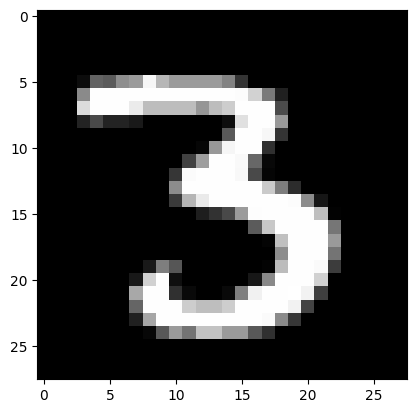

In [17]:
model.eval()
image_idx = 50
image = train_dataset[image_index]
plt.imshow(image.reshape((28,28)), cmap='gray')

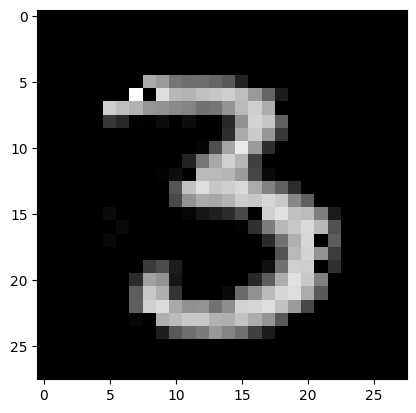

In [18]:
image_gpu = image.cuda()
x_hat = model(image_gpu)
x_hat_cpu = x_hat.detach().cpu().reshape((28,28))
x_hat_cpu = np.around(x_hat_cpu)

plt.imshow(x_hat_cpu, cmap='gray') # reconstructed image

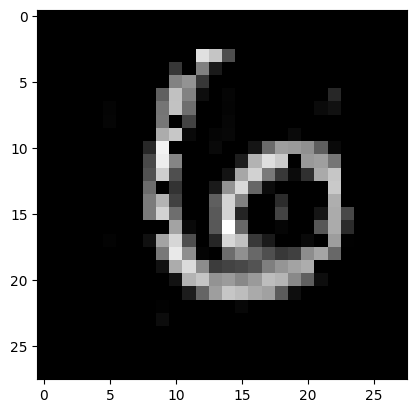

In [19]:
# Visualizing test images
image_idx = 100

image = test_dataset[image_idx].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28,28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray')

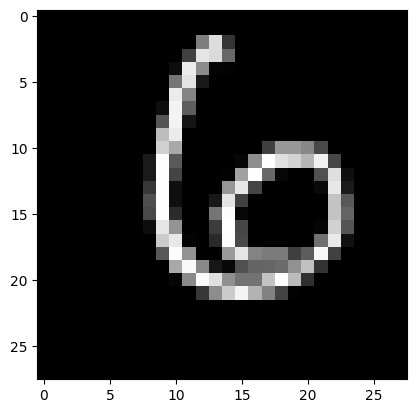

In [20]:
plt.imshow(image.cpu().reshape((28,28)), cmap='gray') # ground truth test image

### Getting latent representation

In [21]:
@torch.no_grad() # wrapping function
def get_latent_representation(model, dataloader):
    latent_representation = []
    for batch in dataloader:
        batch = batch.cuda()
        # Run encoder only
        latent = model.run_encoder(batch)
        latent = latent.cpu().numpy() # due to @torch.no_grad(), detach() not needed
        latent_representation.append(latent)
    latent_representation = np.concatenate(latent_representation)
    return latent_representation

latent = get_latent_representation(model, train_loader)
latent.shape

(60000, 128)

### Extending to VAE

General Architecture:

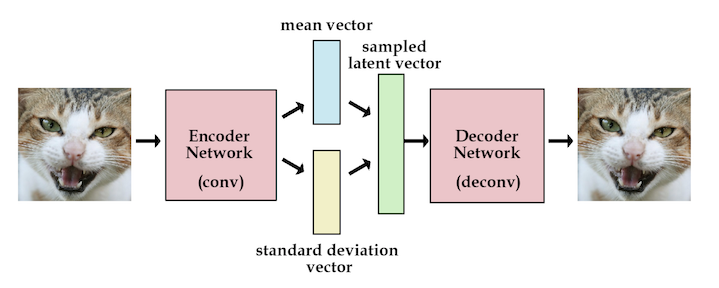

#### VAE Loss function

Evidence Lower Bound :

$ELBO = E_{q(z|x)}logp(x|z) - KL(q(z|x)||p(z))$

$ELBO = Reconstruction Loss - KL Divergence$


KL divergence defined as:

$KL(q(x)||p(x)) = \int{p(x)log(\frac{p(x)}{q(x)})dx}$

In [22]:
kernel_size = 4
init_channels= 8 # initial number of filters
image_channels = 1 # grayscale (MNIST images)
latent_dim = 16 # latent dimension for sampling


In [43]:
class ConvVAE(nn.Module):
    def __init__(self,
                 image_channels=1,
                 kernel_size=4,
                 latent_dim=16,
                 init_channels=8):
        super(ConvVAE, self).__init__()
        
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels,
            out_channels=init_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels,
            out_channels=init_channels*2,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2,
            out_channels=init_channels*4,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4,
            out_channels=init_channels*64,
            kernel_size=kernel_size,
            stride=2,
            padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(512, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim) # log_var : non-negative
        self.fc2 = nn.Linear(latent_dim, 64)
        
        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
    
    def reparameterize(self, mu, log_var):
        # Reparamaterization trick: instead of x ~ N(mu, std),
        # do: x = mu + std * N(0,1)
        # then compute gradients w.r.t mu and std possible
        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std) # initial sample as same size of std
        sample = mu + (eps*std) # actual sampling
        return sample
    
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        
        # print(f"Shape after enc4: {x.shape}")
                
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, output_size=1).reshape(batch, -1)
        
        # print(f"Shape after adaptive_avg_pool2d and reshape: {x.shape}")
        hidden = self.fc1(x)
        # get 'mu' and 'log_var'
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        
        # get latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1) # latent representation
        
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var
        

In [44]:
from torchvision.transforms.functional import to_pil_image
import imageio

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"{epoch}.jpg")
    
def final_loss(bce_loss, mu, logvar):
    """   
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return BCE+KLD

def train(model, dataloader, dataset_size, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(dataset_size/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
            # save last batch input and output of every epoch
            if i==int(len(dataset)/dataloader.batch_size)-1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

### VAE Training

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvVAE().to(device)

lr = 0.001
epochs = 50
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(
    root='./', train=True, download=False, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
testset = torchvision.datasets.MNIST(
    root='./', train=False, download=False, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False
)


In [46]:
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.BCELoss(reduction='sum')

# list to save all the reconstructed images in PyTorch grid format
grid_images = []

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss = train(
        model, trainloader, len(trainset), device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    
    save_reconstructed_images(recon_images, epoch+1)
    # convert reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    


Epoch 1 of 50


938it [00:06, 148.82it/s]                         
157it [00:00, 192.73it/s]                         


Train Loss: 14987.4739
Val Loss: 11202.1929
Epoch 2 of 50


938it [00:06, 145.43it/s]                         
157it [00:00, 208.82it/s]                         


Train Loss: 10324.8377
Val Loss: 9768.4463
Epoch 3 of 50


938it [00:06, 149.80it/s]                         
157it [00:00, 194.47it/s]                         


Train Loss: 9458.8204
Val Loss: 9068.3949
Epoch 4 of 50


938it [00:06, 149.39it/s]                         
157it [00:00, 198.89it/s]                         


Train Loss: 9039.3382
Val Loss: 8810.4950
Epoch 5 of 50


938it [00:06, 145.45it/s]                         
157it [00:00, 197.58it/s]                         


Train Loss: 8805.6803
Val Loss: 8660.4868
Epoch 6 of 50


938it [00:06, 147.43it/s]                         
157it [00:00, 192.14it/s]                         


Train Loss: 8677.6226
Val Loss: 8562.9908
Epoch 7 of 50


938it [00:06, 150.75it/s]                         
157it [00:00, 179.53it/s]                         


Train Loss: 8579.9222
Val Loss: 8466.2563
Epoch 8 of 50


938it [00:06, 148.52it/s]                         
157it [00:00, 190.42it/s]                         


Train Loss: 8494.5638
Val Loss: 8398.1259
Epoch 9 of 50


938it [00:06, 150.61it/s]                         
157it [00:00, 205.03it/s]                         


Train Loss: 8437.5796
Val Loss: 8363.9289
Epoch 10 of 50


938it [00:06, 150.37it/s]                         
157it [00:00, 195.56it/s]                         


Train Loss: 8392.7462
Val Loss: 8338.9639
Epoch 11 of 50


938it [00:06, 150.16it/s]                         
157it [00:00, 187.52it/s]                         


Train Loss: 8357.4845
Val Loss: 8291.9095
Epoch 12 of 50


938it [00:06, 148.02it/s]                         
157it [00:00, 186.20it/s]                         


Train Loss: 8332.1429
Val Loss: 8234.8675
Epoch 13 of 50


938it [00:06, 148.27it/s]                         
157it [00:00, 189.38it/s]                         


Train Loss: 8311.7426
Val Loss: 8217.6363
Epoch 14 of 50


938it [00:06, 151.83it/s]                         
157it [00:00, 207.94it/s]                         


Train Loss: 8296.2304
Val Loss: 8251.1431
Epoch 15 of 50


938it [00:06, 153.87it/s]                         
157it [00:00, 198.31it/s]                         


Train Loss: 8279.1859
Val Loss: 8214.9517
Epoch 16 of 50


938it [00:06, 153.62it/s]                         
157it [00:00, 198.54it/s]                         


Train Loss: 8267.7331
Val Loss: 8202.6581
Epoch 17 of 50


938it [00:06, 154.26it/s]                         
157it [00:00, 209.16it/s]                         


Train Loss: 8253.0034
Val Loss: 8209.6367
Epoch 18 of 50


938it [00:06, 153.06it/s]                         
157it [00:00, 204.12it/s]                         


Train Loss: 8243.5429
Val Loss: 8198.4692
Epoch 19 of 50


938it [00:06, 152.57it/s]                         
157it [00:00, 201.89it/s]                         


Train Loss: 8236.0943
Val Loss: 8201.6658
Epoch 20 of 50


938it [00:06, 153.48it/s]                         
157it [00:00, 206.73it/s]                         


Train Loss: 8226.5209
Val Loss: 8172.5301
Epoch 21 of 50


938it [00:06, 153.25it/s]                         
157it [00:00, 204.51it/s]                         


Train Loss: 8219.4223
Val Loss: 8177.1236
Epoch 22 of 50


938it [00:06, 153.61it/s]                         
157it [00:00, 200.51it/s]                         


Train Loss: 8212.2456
Val Loss: 8157.4064
Epoch 23 of 50


938it [00:06, 152.19it/s]                         
157it [00:00, 207.96it/s]                         


Train Loss: 8205.6668
Val Loss: 8132.3081
Epoch 24 of 50


938it [00:06, 149.85it/s]                         
157it [00:00, 186.28it/s]                         


Train Loss: 8196.0155
Val Loss: 8158.0330
Epoch 25 of 50


938it [00:06, 148.69it/s]                         
157it [00:00, 189.49it/s]                         


Train Loss: 8194.5380
Val Loss: 8158.9138
Epoch 26 of 50


938it [00:06, 149.99it/s]                         
157it [00:00, 208.39it/s]                         


Train Loss: 8189.2432
Val Loss: 8137.2324
Epoch 27 of 50


938it [00:06, 153.08it/s]                         
157it [00:00, 194.66it/s]                         


Train Loss: 8185.9061
Val Loss: 8134.6660
Epoch 28 of 50


938it [00:06, 154.49it/s]                         
157it [00:00, 209.53it/s]                         


Train Loss: 8177.0466
Val Loss: 8134.5054
Epoch 29 of 50


938it [00:06, 153.44it/s]                         
157it [00:00, 206.37it/s]                         


Train Loss: 8171.7567
Val Loss: 8164.9963
Epoch 30 of 50


938it [00:06, 154.03it/s]                         
157it [00:00, 209.75it/s]                         


Train Loss: 8166.7171
Val Loss: 8120.7407
Epoch 31 of 50


938it [00:06, 150.29it/s]                         
157it [00:00, 191.23it/s]                         


Train Loss: 8165.9970
Val Loss: 8122.8060
Epoch 32 of 50


938it [00:06, 152.43it/s]                         
157it [00:00, 198.52it/s]                         


Train Loss: 8160.1400
Val Loss: 8138.1007
Epoch 33 of 50


938it [00:06, 149.57it/s]                         
157it [00:00, 193.69it/s]                         


Train Loss: 8159.0045
Val Loss: 8103.1197
Epoch 34 of 50


938it [00:06, 149.49it/s]                         
157it [00:00, 192.00it/s]                         


Train Loss: 8153.4820
Val Loss: 8122.8870
Epoch 35 of 50


938it [00:06, 150.73it/s]                         
157it [00:00, 195.20it/s]                         


Train Loss: 8149.9821
Val Loss: 8119.6917
Epoch 36 of 50


938it [00:06, 152.99it/s]                         
157it [00:00, 195.38it/s]                         


Train Loss: 8148.9067
Val Loss: 8129.2359
Epoch 37 of 50


938it [00:06, 147.80it/s]                         
157it [00:00, 204.81it/s]                         


Train Loss: 8145.3011
Val Loss: 8129.2866
Epoch 38 of 50


938it [00:06, 150.38it/s]                         
157it [00:00, 194.15it/s]                         


Train Loss: 8142.4718
Val Loss: 8113.5458
Epoch 39 of 50


938it [00:06, 152.47it/s]                         
157it [00:00, 204.26it/s]                         


Train Loss: 8138.5274
Val Loss: 8129.0068
Epoch 40 of 50


938it [00:06, 152.82it/s]                         
157it [00:00, 182.71it/s]                         


Train Loss: 8137.8680
Val Loss: 8099.0792
Epoch 41 of 50


938it [00:06, 148.87it/s]                         
157it [00:00, 187.61it/s]                         


Train Loss: 8131.8212
Val Loss: 8088.9431
Epoch 42 of 50


938it [00:06, 151.98it/s]                         
157it [00:00, 195.34it/s]                         


Train Loss: 8129.8284
Val Loss: 8099.3899
Epoch 43 of 50


938it [00:06, 153.18it/s]                         
157it [00:00, 192.95it/s]                         


Train Loss: 8129.5360
Val Loss: 8080.3328
Epoch 44 of 50


938it [00:06, 153.24it/s]                         
157it [00:00, 194.05it/s]                         


Train Loss: 8125.3099
Val Loss: 8078.9619
Epoch 45 of 50


938it [00:06, 152.42it/s]                         
157it [00:00, 207.52it/s]                         


Train Loss: 8125.0259
Val Loss: 8075.5701
Epoch 46 of 50


938it [00:06, 154.25it/s]                         
157it [00:00, 201.50it/s]                         


Train Loss: 8121.9347
Val Loss: 8079.8548
Epoch 47 of 50


938it [00:06, 153.54it/s]                         
157it [00:00, 192.28it/s]                         


Train Loss: 8117.7407
Val Loss: 8083.5356
Epoch 48 of 50


938it [00:06, 154.82it/s]                         
157it [00:00, 207.62it/s]                         


Train Loss: 8115.0474
Val Loss: 8063.8202
Epoch 49 of 50


938it [00:06, 155.46it/s]                         
157it [00:00, 198.98it/s]                         


Train Loss: 8112.4478
Val Loss: 8071.4238
Epoch 50 of 50


938it [00:06, 153.24it/s]                         
157it [00:00, 205.48it/s]                         

Train Loss: 8115.0406
Val Loss: 8081.8813


### Image show test, make_grid

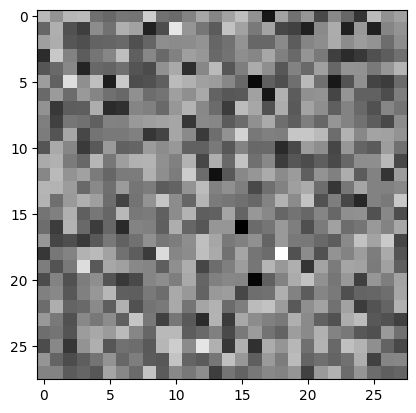

In [63]:
import torch
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# 재구성된 이미지 텐서 (예시)
recon_images = torch.randn(16, 1, 28, 28)  # 16개의 28x28 크기의 이미지

# 그리드 이미지 시각화
# plt.imshow(recon_images[0,:,:,:].permute(1, 2, 0), cmap='gray')
plt.imshow(recon_images[0,0,:,:], cmap='gray')

# plt.imshow(image_grid.permute(1, 2, 0), cmap='gray')
plt.show()


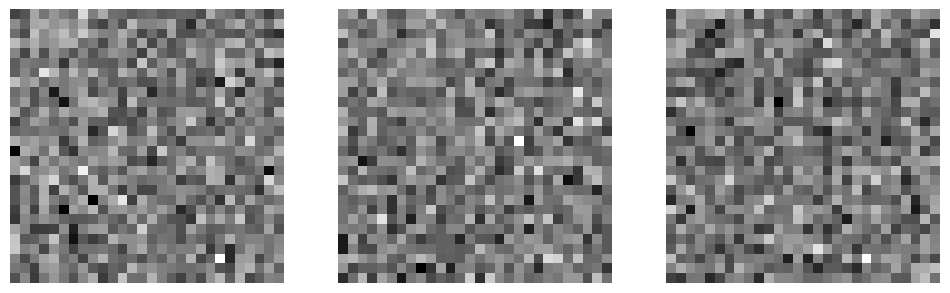

In [64]:
import torch
import matplotlib.pyplot as plt

# 16개의 1채널 28x28 이미지 텐서 생성
recon_images = torch.randn(16, 1, 28, 28)

# 여러 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    image = recon_images[i, 0, :, :]  # (1, 28, 28)에서 (28, 28)으로 차원 축소
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')  # 축 제거

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


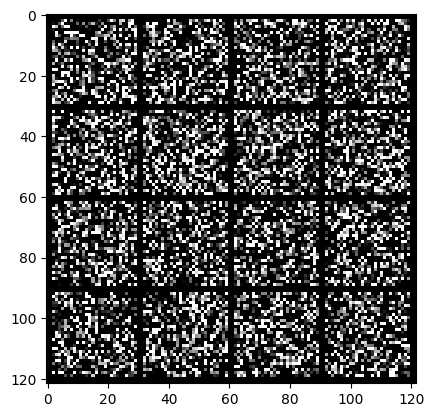

In [66]:
import torch
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# 재구성된 이미지 텐서 (예시)
recon_images = torch.randn(16, 1, 28, 28)  # 16개의 28x28 크기의 이미지

# 이미지 텐서를 그리드로 변환
image_grid = make_grid(recon_images.detach().cpu(), nrow=4)  # 4개의 이미지를 한 행에

# 그리드 이미지를 리스트에 추가
# grid_images = []
# grid_images.append(image_grid)

# 그리드 이미지 시각화
plt.imshow(image_grid.permute(1, 2, 0), cmap='gray')
plt.show()
